# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 12: Hetronuclear Nuclear Overhauser effect (NOE)
In this tutorial you will see Hetronuclear Nuclear Overhauser effect (NOE) of two spin half system (H1 and C13). We will evolve the density matrix in Liouville Space. Correlation time 10 pico second. 

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaC13]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 11.4

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [0,0] # Offset frequency in Hz

"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-485.38291502 -122.07564834]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = True

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  1.0


In [8]:
"""
Equlibrium population of Carbon and Proton
"""
print("Equlibrium Population of H1 = ", np.trace(Sz[0] @ rhoeq).real)
print("Equlibrium Population of C13 = ", np.trace(Sz[1] @ rhoeq).real)

Equlibrium Population of H1 =  1.9410853512036308e-05
Equlibrium Population of C13 =  4.88190345199202e-06


## Zeeman Halitonian in Rotating Frame

In [9]:
OmegaRF = [-System.gammaH1*B0,-System.gammaC13*B0]
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## J Coupling Hamiltonian

In [10]:
'''
Define J couplings between individual spins
'''
Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 15.0
Hj = System.Jcoupling_Weak(Jlist,Sz)

## Converting to Liouvillian

In [11]:
Hz_L = System.CommutationSuperoperator(Hz)
Hzr_L = System.CommutationSuperoperator(Hzr)
Hj_L = System.CommutationSuperoperator(Hj)
rho_in_L = System.Vector_L(rho_in)
rhoeq_L = System.Vector_L(rhoeq)

## Pulse

In [12]:
"""
Selective Pulse on Spin 1
""";
pulse_angle = 180.0
rho_L = System.Rotate_L(rho_in_L,pulse_angle,Sx[0]) 

## Relaxation Constant

In [13]:
"""
Options: "No Relaxation", "Phenomenological", "Auto-correlated Dipolar Homonuclear", Auto-correlated Dipolar Hetronuclear
""";
R = None 
Rprocess = "Auto-correlated Dipolar Hetronuclear"
tau = 10.0e-12
bIS = 30.0e3
System.Relaxation_Parameters(LarmorF, OmegaRF, tau, bIS)
R_L = System.Relaxation_L(Rprocess,R,Sx,Sy,Sz,Sp,Sm)

## Evolution of Density Matrix

In [14]:
dt = 0.0005
AQ = 60.0
Npoints = int(AQ/dt)
print("Number of points in the simulation", Npoints)

"""
option for solver, "method": "Unitary Propagator", "Relaxation" or "ODE Solver"
"""
method = "Relaxation"

start_time = time.time()
t, rho_t = System.Evolution_L(rhoeq_L,rho_L,Sx,Sy,Hzr_L + Hj_L - 1j * R_L,dt,Npoints,method)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Number of points in the simulation 120000
Total time = 0.38230252265930176 seconds 


## Expectation value

In [15]:
EXP_Z1 = Sz[0]
EXP_Z2 = Sz[1]

LEXP_Z1 = System.Detection_L(EXP_Z1)
LEXP_Z2 = System.Detection_L(EXP_Z2)

t, Mz1 = System.Expectation_L(rho_t,LEXP_Z1,dt,Npoints)
t, Mz2 = System.Expectation_L(rho_t,LEXP_Z2,dt,Npoints)

<IPython.core.display.Javascript object>


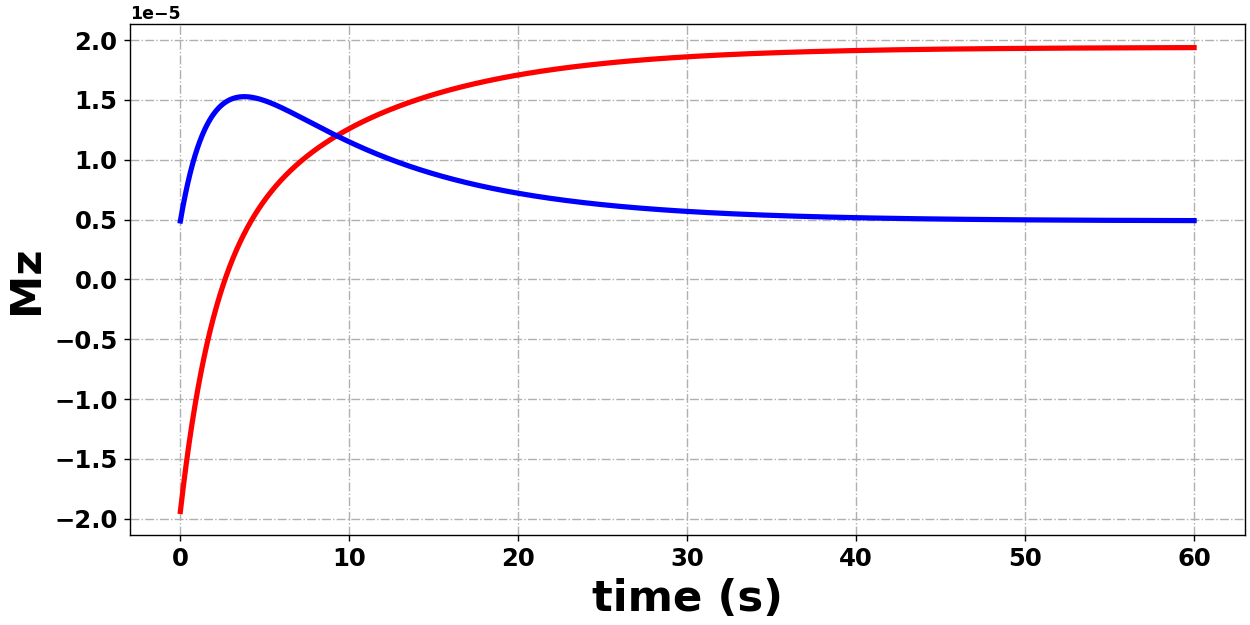

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [16]:
"""
Mz1: Red
Mz2: Blue
"""
System.PlottingMulti(4,[t,t],[Mz1,Mz2],"time (s)","Mz",["red","blue"])

<IPython.core.display.Javascript object>


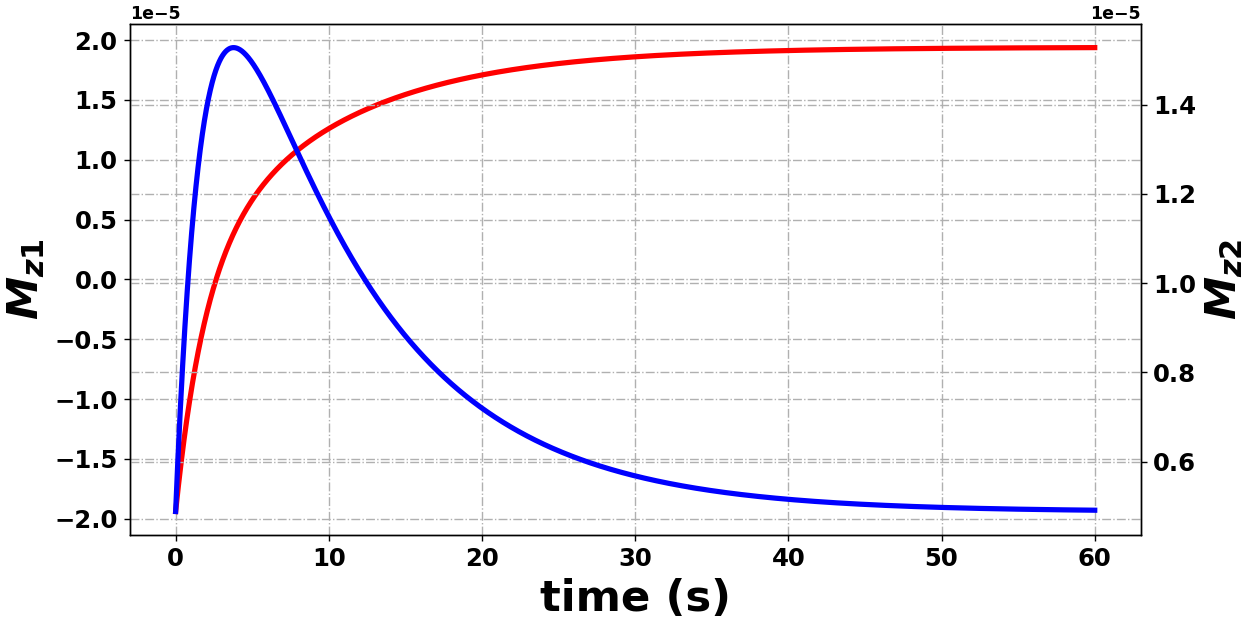

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [17]:
"""
Mz1: Red
Mz2: Blue
"""
System.PlottingTwin(5,t,Mz1,Mz2,"time (s)",r"$M_{z1}$",r"$M_{z2}$","red","Blue")

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com